In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
from scipy.optimize import fsolve 
import sys
import time
from scipy import optimize
from numpy import savetxt

In [2]:
Dimensions=100
Dimensions_1 = 50
Dimensions_2= 50
PI = np.pi
K = 0.5631
DEGREE = 2
global Dimensions, PI, K,DEGREE

In [3]:
a1=np.linspace(1e-12,0.5-(0.999-0.5)/Dimensions_2, Dimensions_1) 
a2=np.linspace(0.5,0.999, Dimensions_2) 
C_RANGES= np.reshape(np.concatenate((a1, a2), axis=0), (-1,1))
THETA_RANGES = np.linspace(0, 2*PI, Dimensions)

In [4]:
def pertubation(theta, N):
    return np.cos(N*theta)

In [5]:
def dev_pertubation(theta, N):
    return -N*np.sin(N*theta)

In [6]:
def radius(theta, c, m, N, Pertubation):
    pertu = pertubation(theta, N)
    scalling = 1/(np.power((1+c), m))##########Test
    r = (scalling*(1-c)+(np.power(1-c, m**DEGREE)*Pertubation*pertu))*K###use 0.561 to sure the surface = 1
    return r

In [7]:
def Dev_r_theta(theta, c, m, N, Pertubation):
    dev_per = dev_pertubation(theta, N)
    d_r = Pertubation*np.power((1-c), m**DEGREE)*dev_per
    return d_r

In [8]:
def Dev_r_c(theta, c, m, N,Pertubation):
    pertu = pertubation(theta, N)*Pertubation
    A = 1/(np.power((1+c), m))
    B = (1-c)*K
    dA = -m*np.power(1+c, -m-1)
    dB = -K
    dC = -K*pertu*(m**DEGREE)*((1-c)**((m**DEGREE)-1))####require C != 1, when C == 1, there will be a signarity.
    d_r = A*dB+B*dA+dC
    return d_r

In [9]:
def Dev_h_c(c, n):
    d_h = n*np.power(c, n-1)####set c_max=1
    return d_h

In [10]:
def Height_volume(v, n, M, Radius, Theta_ranges, C_ranges, N_circular, Pertubation):
    dimen_c = len(C_ranges)
    
    d_theta = Theta_ranges[1]-Theta_ranges[0]#(Theta_ranges[-1]-Theta_ranges[0])/Dimensions
    C_RANGES_diff = np.diff(C_ranges, axis=0)
    C_RANGES_diff = np.reshape(np.append(C_RANGES_diff, C_RANGES_diff[-1,0] ), (-1,1))
    d_c = C_RANGES_diff
    d_base_area = 0.5*(Radius**2)*d_theta


    d_h = Dev_h_c(C_ranges, n)
    dv = (d_base_area*d_h)*d_c

    volume = np.sum(dv)

    H = v/volume
     
    d_r_theta = Dev_r_theta(Theta_ranges, C_ranges, M, N_circular, Pertubation)
    d_r_c = Dev_r_c(Theta_ranges, C_ranges, M, N_circular, Pertubation)
  
    d_h_c = H*d_h
    
    
    ds = np.sqrt(Radius**2+d_r_theta**2)*d_theta
    dl = np.sqrt(d_r_c**2+d_h_c**2)*d_c
    
    surface = ds*dl

    
    surface_size = np.sum(surface)
    
    return H, surface_size

In [11]:
def Main(v, n_ranges, m_ranges, Theta_ranges, C_ranges, N_circular, Pertubation):
    n_length = len(n_ranges)
    m_length = len(m_ranges)
    surface_matrix = np.zeros((m_length, n_length))
    height_matrix = np.zeros((m_length, n_length))
    for i in range(m_length):
        Radius = radius(Theta_ranges, C_ranges, m_ranges[i], N_circular, Pertubation)
        for j in range(n_length):
            height, surface = Height_volume(v, n_ranges[j], m_ranges[i], Radius,
                                            Theta_ranges, C_ranges, N_circular, Pertubation)
            surface_matrix[i][j] = surface
            height_matrix[i][j] = height
    surface_min = surface_matrix.min()
    index = np.where(surface_matrix==np.min(surface_matrix))
    height_min = height_matrix[index][0]
    return surface_min, height_min, surface_matrix

In [12]:
def loop_volume(v, N_circular, Pertubation):
    m_l=[1, 0.5,0.1,0.05,0.01,0.005,0.001]
    n_l=[0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
    levels = len(m_l)
    n_start = 0.5
    n_stop = 3
    m_start = -10
    m_stop = 20
    i = 0 
    Start = True
    while (i<levels):
        dimen = 200
        if (Start==True):
            m_ranges = np.arange(m_start, m_stop, m_l[i])
            n_ranges = np.arange(n_start,n_stop, n_l[i])
            Start = False
        else:
            pass
#         print(m_ranges)
#         print(n_ranges)
        s_g, h_g,energy_g= Main(v,n_ranges, m_ranges, THETA_RANGES, C_RANGES, N_circular, Pertubation)
        index = np.where(energy_g == np.min(energy_g))
        m = index[0][0]
        n = index[1][0]
#         print('i', i)
#         print('m', m)
#         print('n', n)
        m_lst_index = len(m_ranges)-1
        n_lst_index = len(n_ranges)-1
        if (m ==0)|(m==m_lst_index)|(n==0)|(n==n_lst_index):
            m_ranges = np.arange(m_ranges[m]-m_l[i], m_ranges[m]+2*m_l[i], m_l[i])
            n_ranges = np.arange(n_ranges[n]-n_l[i], n_ranges[n]+2*n_l[i], n_l[i])
        else:
            if (i+1) <levels:
                m_ranges = np.arange(m_ranges[m]-m_l[i], m_ranges[m]+m_l[i]+m_l[i+1], m_l[i+1])
                n_ranges = np.arange(n_ranges[n]-n_l[i], n_ranges[n]+n_l[i]+n_l[i+1], n_l[i+1])
                i = i+1
            else:
                break
    surface = s_g
    height = h_g
    Energy = energy_g
    return surface, height, Energy,  m_ranges[m], n_ranges[n]

### Pertubation = 0.01, 0.02,0.05,0.07

In [13]:
Volume = 0.1
N_c = 4
Pers = [0.01,0.02,0.05,0.07, 0.1]
Surface = []
Height = []
Energy = []
m_matrix = []
n_matrix = []
for per in Pers:
    s,h,e,m,n = loop_volume(Volume, N_c,per)
    Surface.append(s)
    Height.append(h)
    Energy.append(e)
    m_matrix.append(m)
    n_matrix.append(n)

In [14]:
Height

[0.23775434272066684,
 0.24000668574420228,
 0.2424135757638782,
 0.24330414454538785,
 0.2429281495024823]

In [15]:
Surface

[1.1284423867936377,
 1.1310477769135474,
 1.1472495924751611,
 1.1633910816890773,
 1.1931203786850326]

In [16]:
m_matrix

[-0.9459999999999995,
 -0.9769999999999995,
 -1.0110000000000001,
 -1.043,
 -1.0880000000000005]

In [17]:
n_matrix

[1.4147000000000018,
 1.4758000000000044,
 1.5466999999999969,
 1.6033999999999986,
 1.6722000000000012]

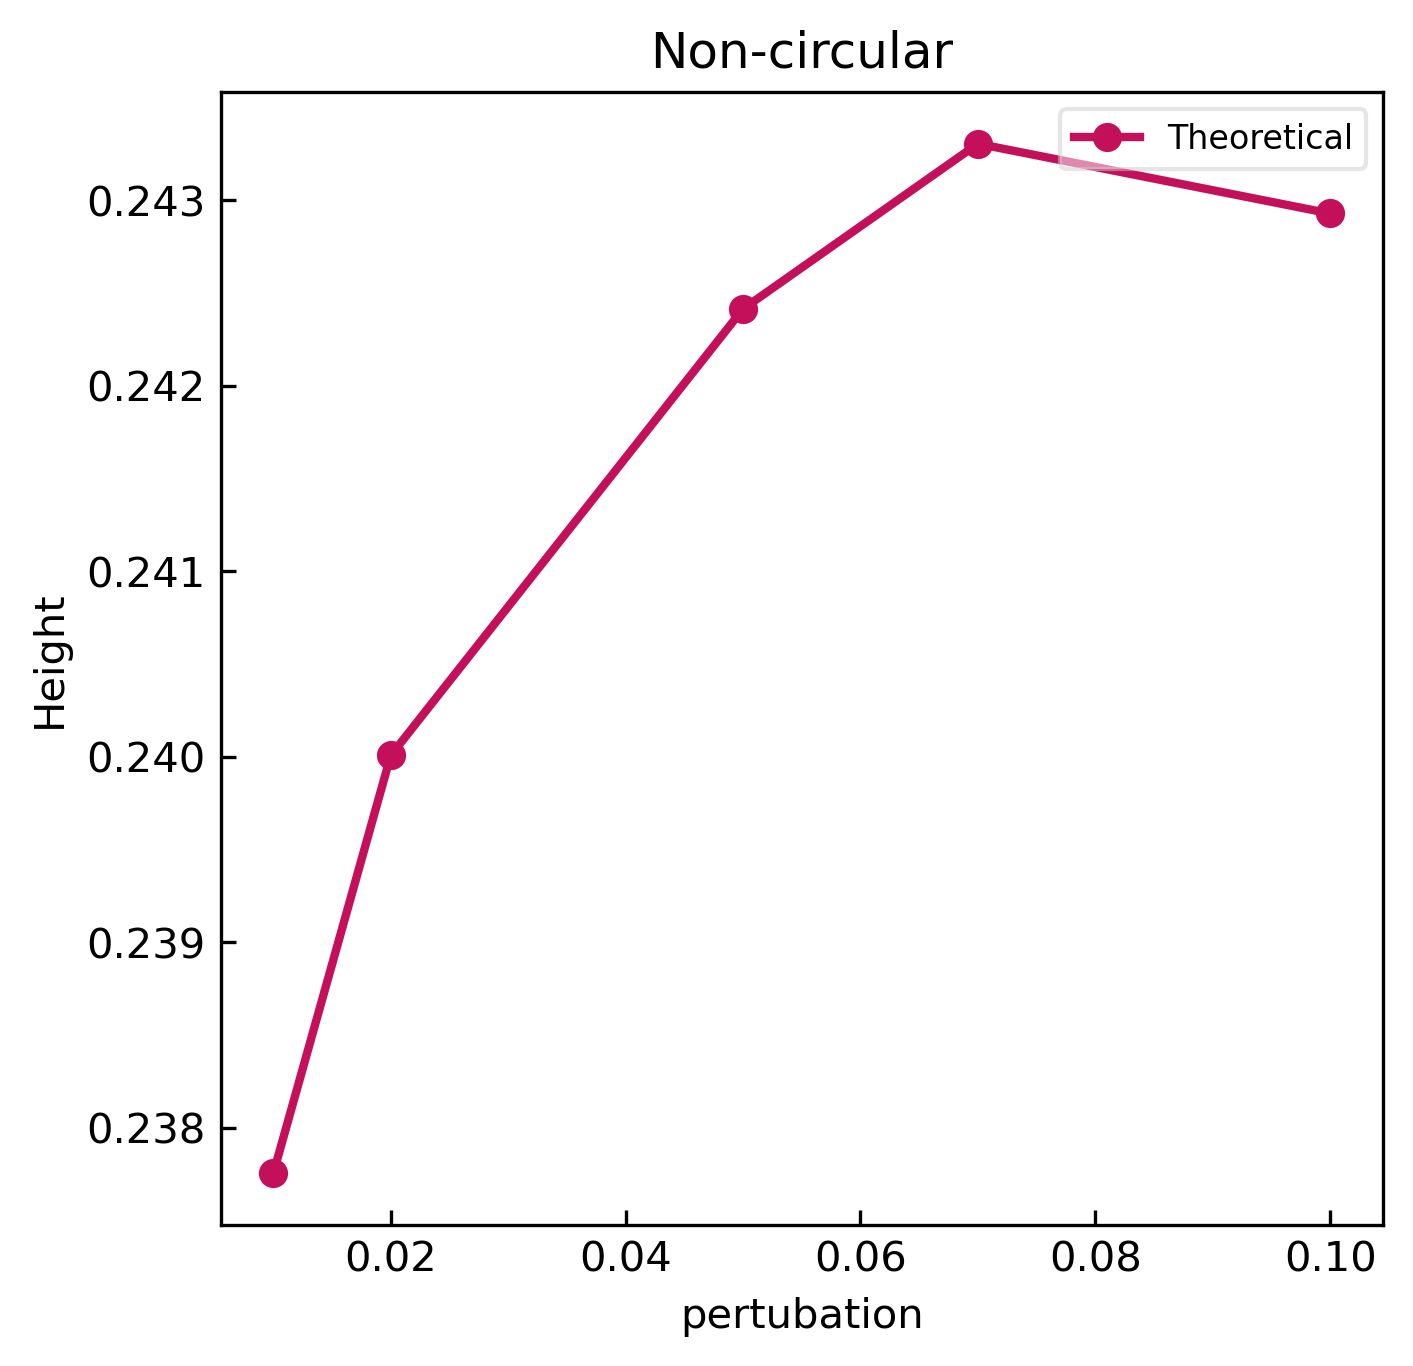

In [18]:
fig = plt.figure(figsize=(5,5), dpi=300)
ax_1=fig.add_subplot(1,1,1)




ax_1.plot(Pers,Height,color="#C40f5B",lw =2, marker = 'o', label = 'Theoretical')

ax_1.set_title('Non-circular')
ax_1.set_ylabel('Height')
ax_1.set_xlabel('pertubation')


ax_1.legend(loc='upper right', fontsize=8, numpoints=1, framealpha=0.5)
ax_1.tick_params(axis="y", direction='in')
ax_1.tick_params(axis="x", direction='in')
plt.savefig('non_circular_Height_pertubation.pdf', bbox_inches='tight')

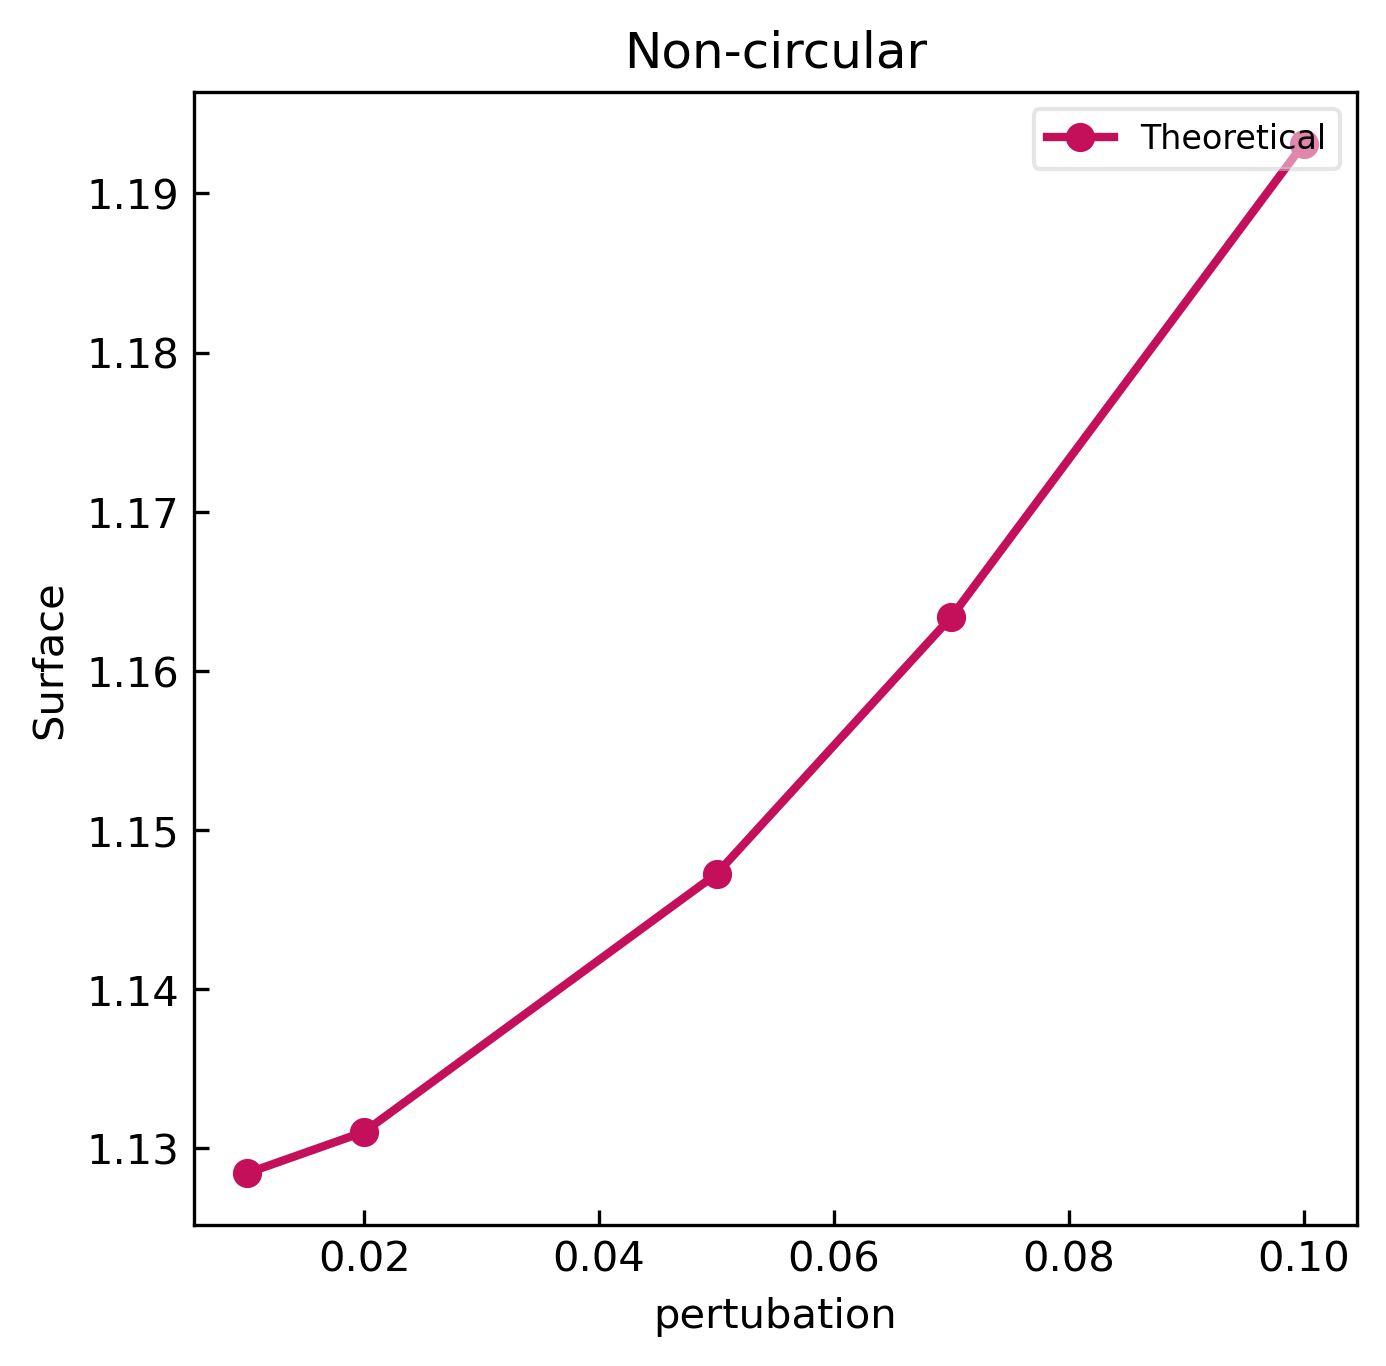

In [19]:
fig = plt.figure(figsize=(5,5), dpi=300)
ax_1=fig.add_subplot(1,1,1)




ax_1.plot(Pers,Surface,color="#C40f5B",lw =2, marker = 'o', label = 'Theoretical')


ax_1.set_title('Non-circular')
ax_1.set_ylabel('Surface')
ax_1.set_xlabel('pertubation')

ax_1.legend(loc='upper right', fontsize=8, numpoints=1, framealpha=0.5)
ax_1.tick_params(axis="y", direction='in')
ax_1.tick_params(axis="x", direction='in')
plt.savefig('non_circular_surface_pertubation.pdf', bbox_inches='tight')

## Pertubation = 0.01

In [20]:
Radius = radius(THETA_RANGES, C_RANGES, m_matrix[0], 4, Pers[0])
Radius.shape
x = Radius*np.cos(THETA_RANGES)
y = Radius*np.sin(THETA_RANGES)
z = Height[0]*(C_RANGES)**n_matrix[0]
z_0 = np.ones(THETA_RANGES.shape[0])

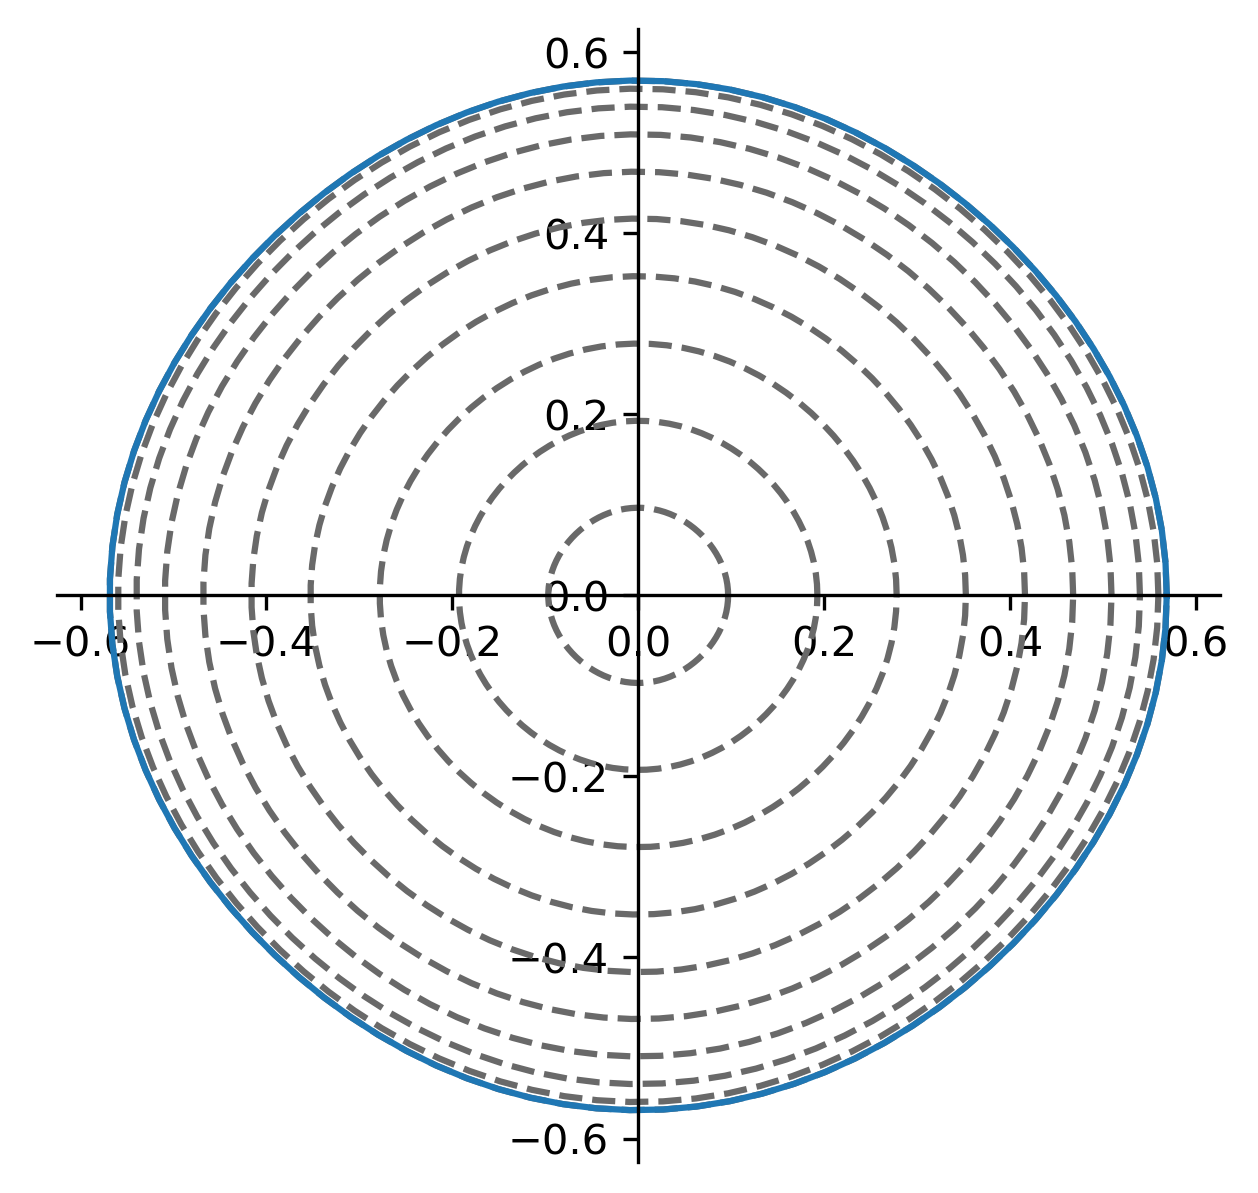

In [21]:
fig = plt.figure(figsize=(5,5), dpi=300)
ax=fig.add_subplot(1,1,1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in np.arange(0,100,10):
    ax.plot(x[i], y[i],linestyle='--',color='dimgrey')

ax.plot(x[0], y[0])
fig.savefig('Non-circular-per001.pdf', bbox_inches='tight')

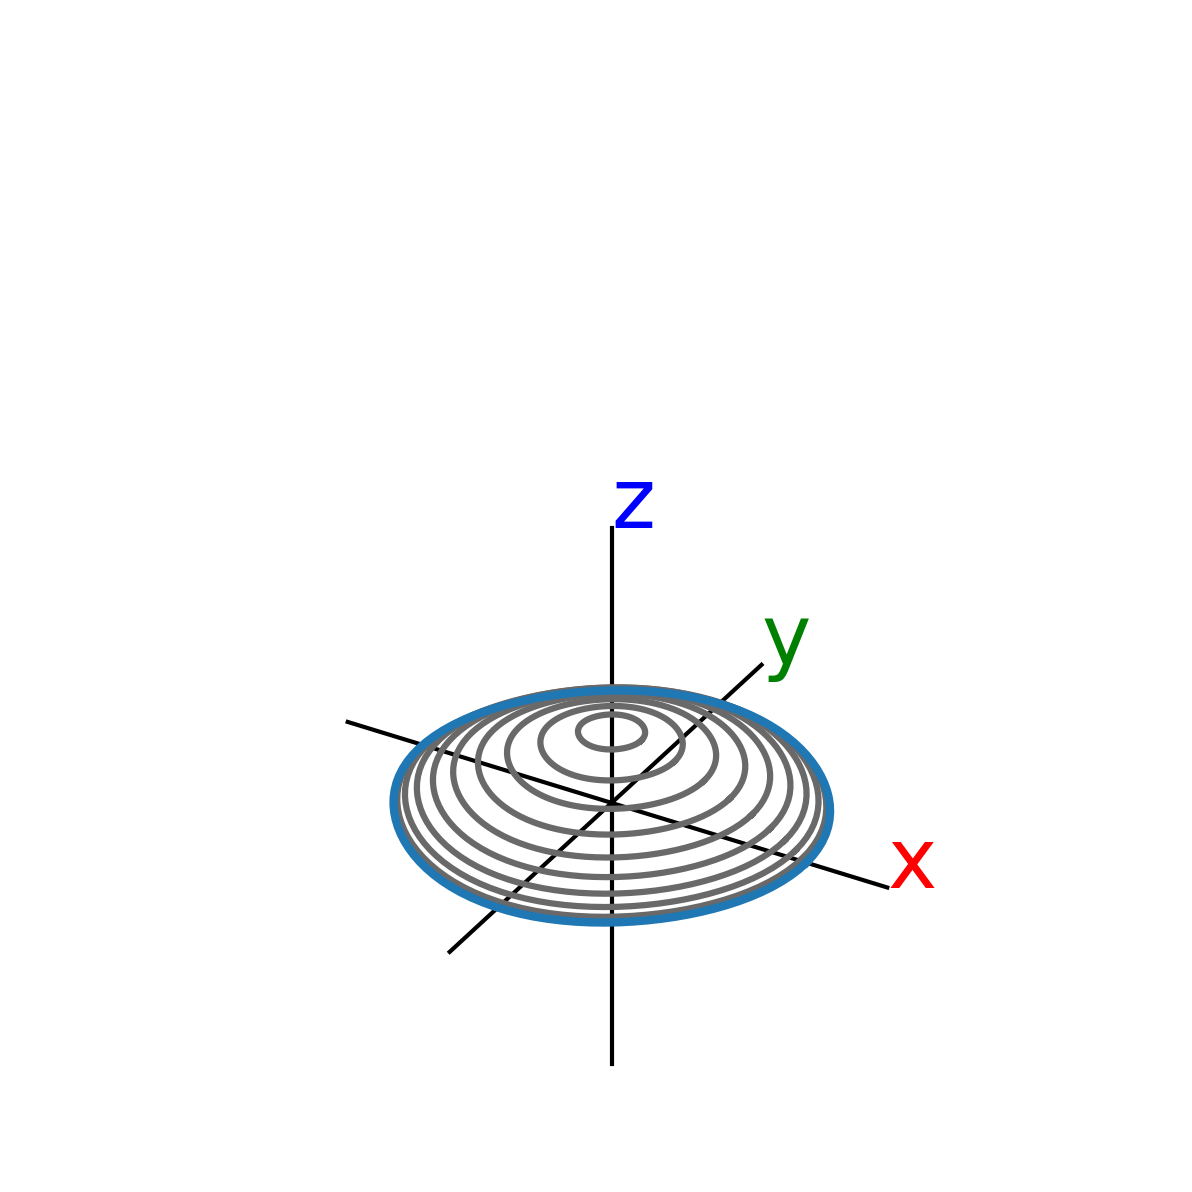

In [22]:
fig = plt.figure(figsize = (5,5), dpi=300)
ax = plt.axes(projection='3d')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

val = [0.8,0,0]
labels = ['x', 'y', 'z']
colors = ['r', 'g', 'b']
for v in range(3):
    axx = [val[v-0], -val[v-0]]
    axy = [val[v-1], -val[v-1]]
    axz = [val[v-2], -val[v-2]]
    ax.plot(axx,axy,axz,'k-', linewidth=1)
    ax.text(val[v-0], val[v-1], val[v-2], labels[v], color=colors[v], fontsize=20)


for i in np.arange(1,100,10):
        ax.plot(x[i], y[i],z_0*z[i], color='dimgrey')
ax.plot(x[0], y[0],z_0*z[0], lw=2)
ax.set_zlim(0,1.3)
ax.set_axis_off()
ax.grid(False)
fig.savefig('Non-circular-per001_with_xyz.pdf', bbox_inches='tight')

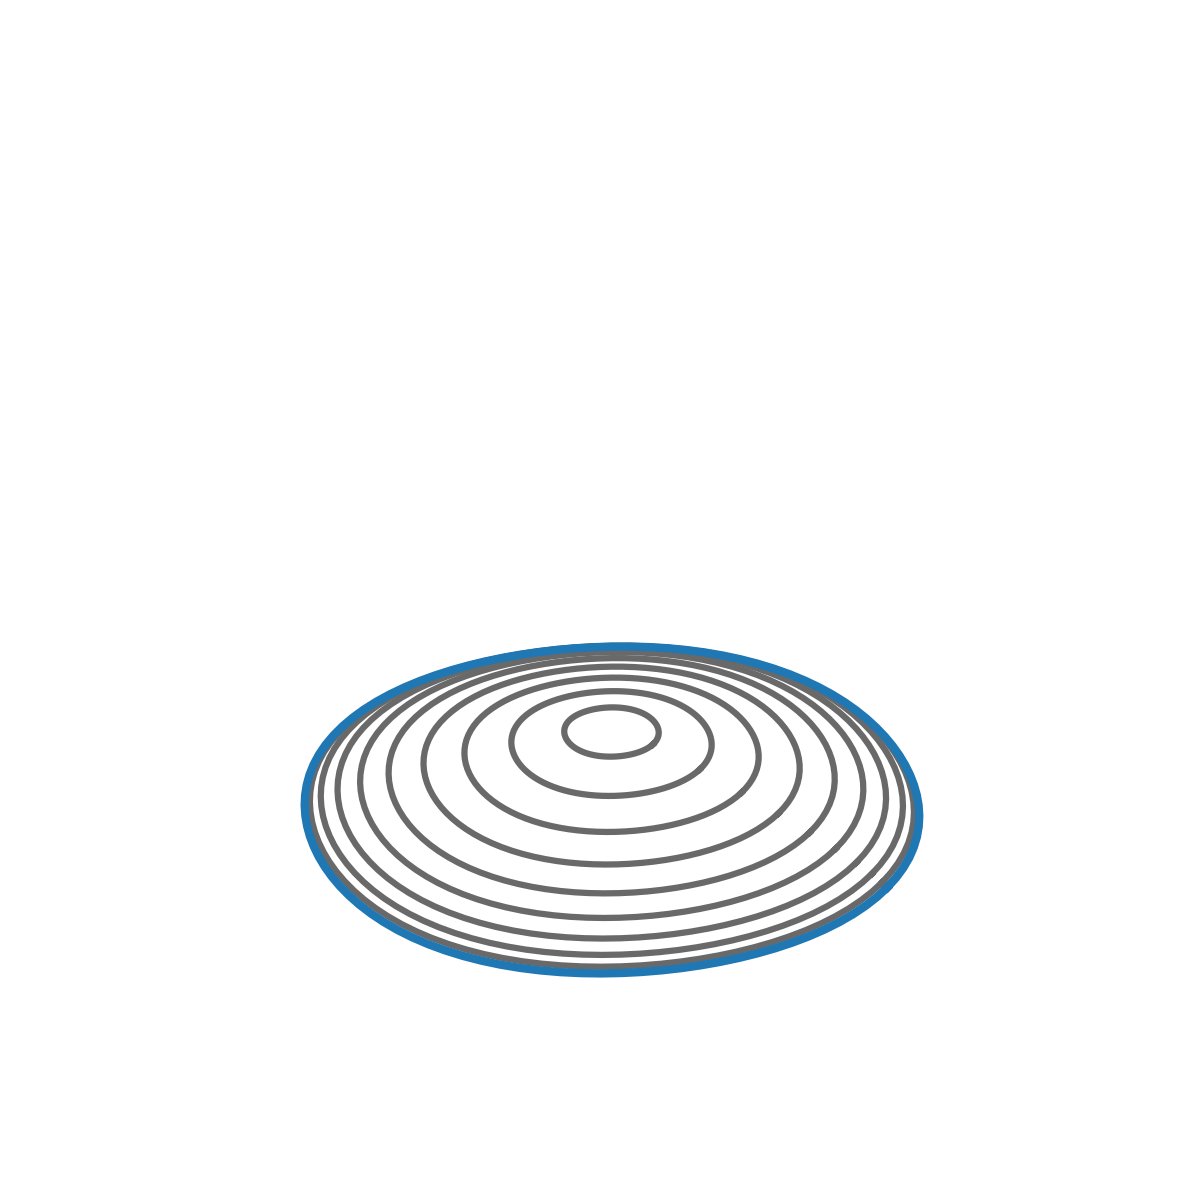

In [23]:
fig = plt.figure(figsize = (5,5), dpi=300)
ax = plt.axes(projection='3d')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(1,100,10):
        ax.plot(x[i], y[i],z_0*z[i], color='dimgrey')
ax.plot(x[0], y[0],z_0*z[0], lw=2)
ax.set_zlim(0,1.3)
ax.set_axis_off()
ax.grid(False)
fig.savefig('Non-circular-per001_3D.pdf', bbox_inches='tight')

## Pertubation = 0.02

In [24]:
Radius = radius(THETA_RANGES, C_RANGES, m_matrix[1], 4, Pers[1])
Radius.shape
x = Radius*np.cos(THETA_RANGES)
y = Radius*np.sin(THETA_RANGES)
z = Height[1]*(C_RANGES)**n_matrix[1]
z_0 = np.ones(THETA_RANGES.shape[0])

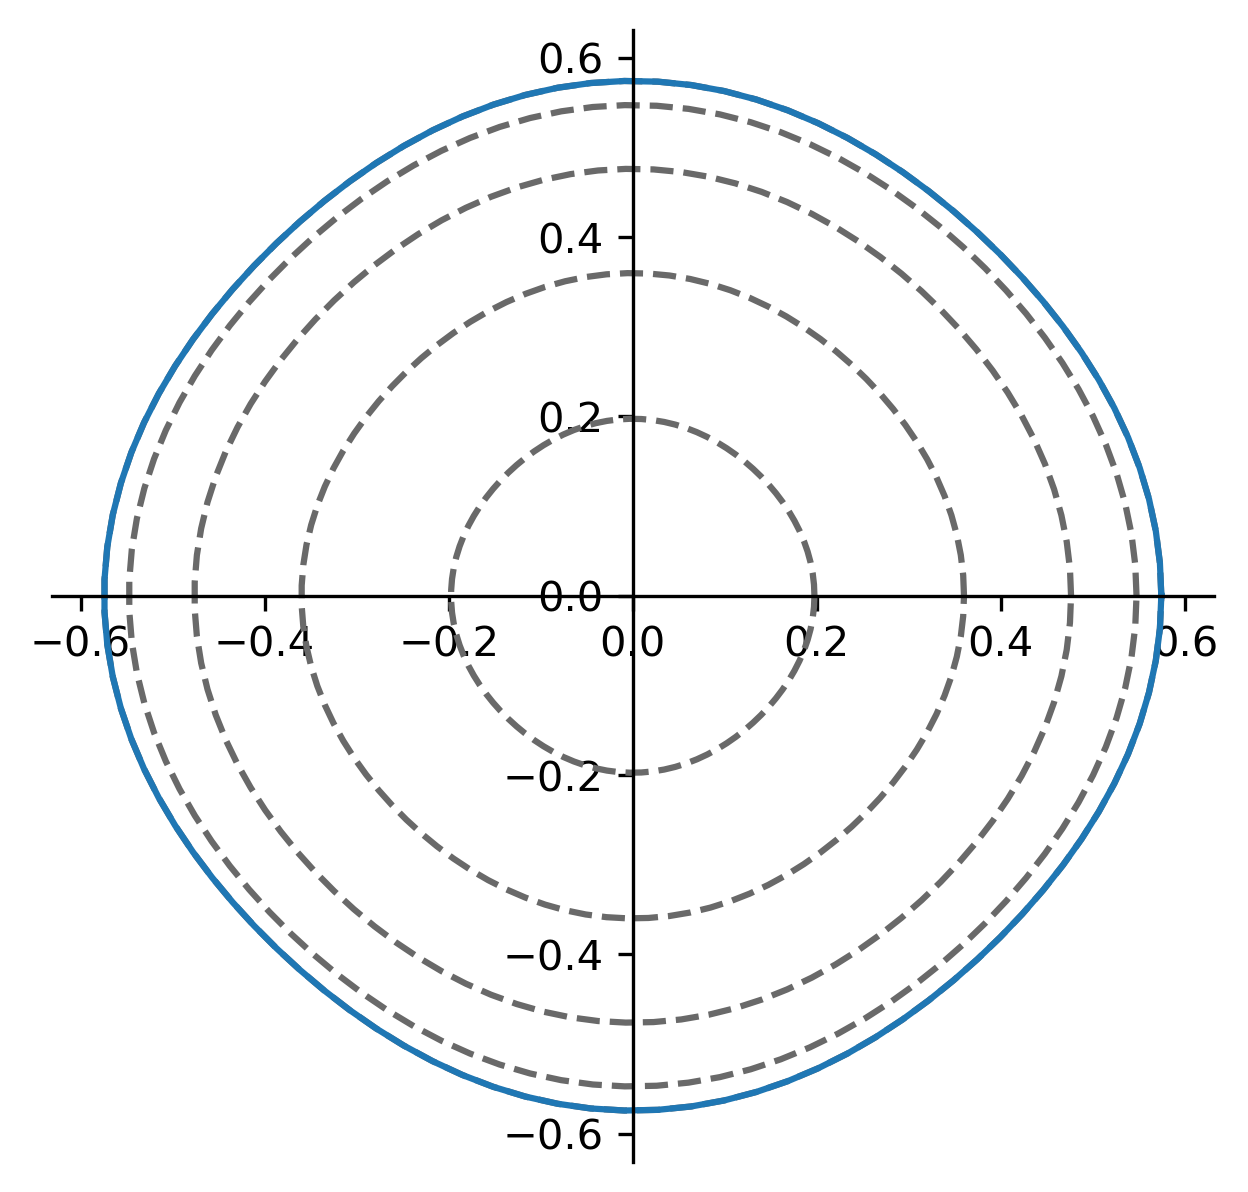

In [25]:
fig = plt.figure(figsize=(5,5), dpi=300)
ax=fig.add_subplot(1,1,1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in np.arange(0,100,20):
    ax.plot(x[i], y[i],linestyle='--',color='dimgrey')

ax.plot(x[0], y[0])
fig.savefig('Non-circular-per002.pdf', bbox_inches='tight')

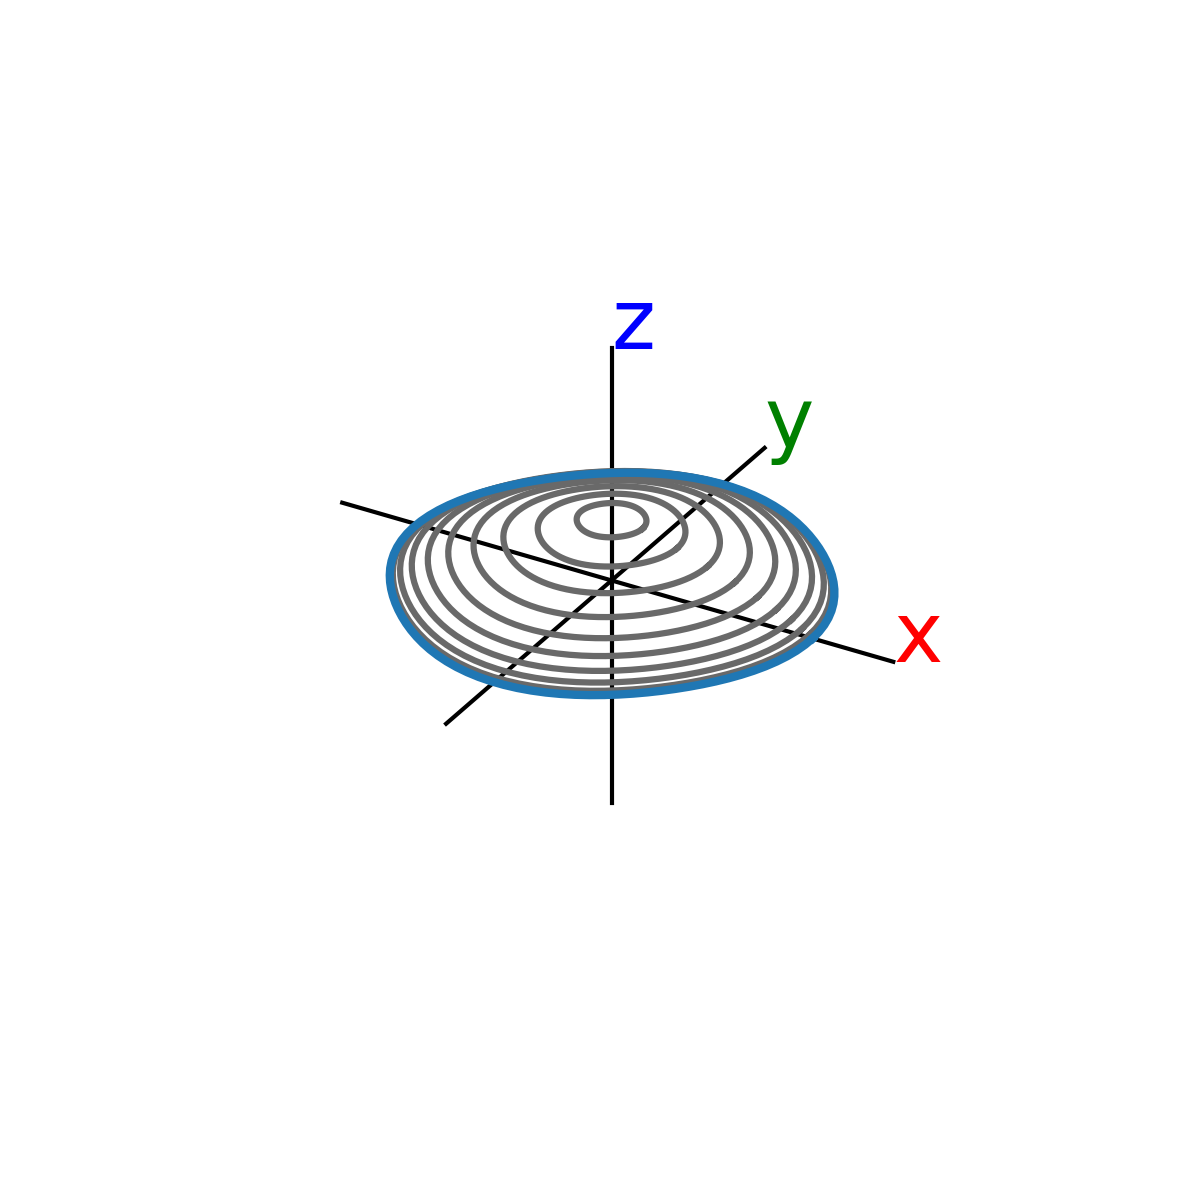

In [26]:
fig = plt.figure(figsize = (5,5), dpi=300)
ax = plt.axes(projection='3d')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

val = [0.8,0,0]
labels = ['x', 'y', 'z']
colors = ['r', 'g', 'b']
for v in range(3):
    axx = [val[v-0], -val[v-0]]
    axy = [val[v-1], -val[v-1]]
    axz = [val[v-2], -val[v-2]]
    ax.plot(axx,axy,axz,'k-', linewidth=1)
    ax.text(val[v-0], val[v-1], val[v-2], labels[v], color=colors[v], fontsize=20)


for i in np.arange(1,100,10):
        ax.plot(x[i], y[i],z_0*z[i], color='dimgrey')
ax.plot(x[0], y[0],z_0*z[0], lw=2)
# ax.set_zlim(0,1.3)
ax.set_axis_off()
ax.grid(False)
fig.savefig('Non-circular-per002_with_xyz.pdf', bbox_inches='tight')

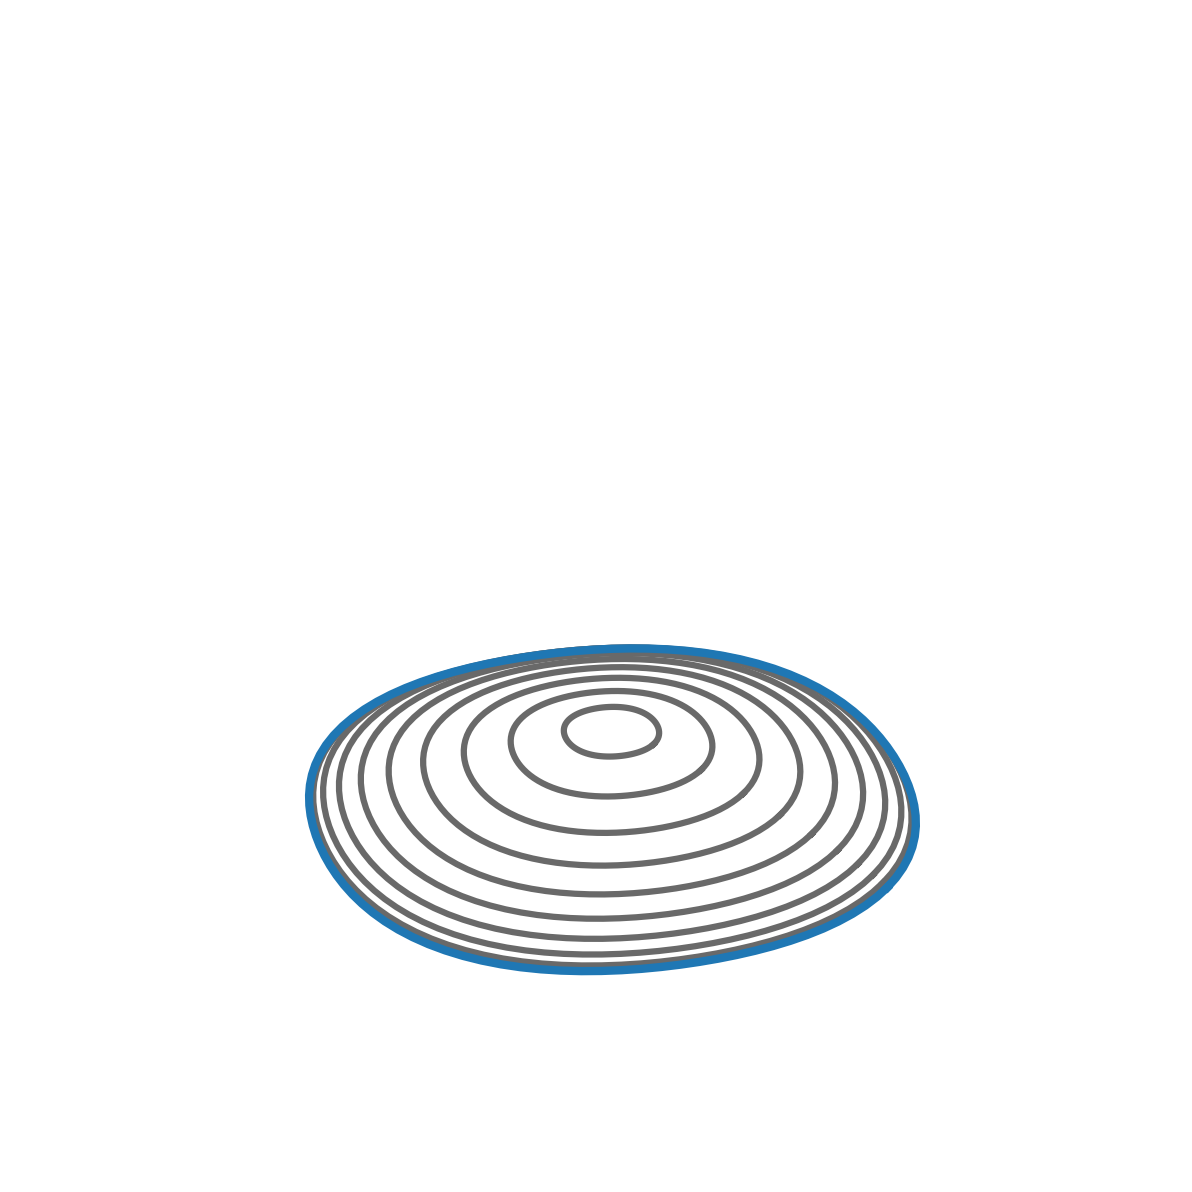

In [27]:
fig = plt.figure(figsize = (5,5), dpi=300)
ax = plt.axes(projection='3d')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(1,100,10):
        ax.plot(x[i], y[i],z_0*z[i], color='dimgrey')
ax.plot(x[0], y[0],z_0*z[0], lw=2)
ax.set_zlim(0,1.3)
ax.set_axis_off()
ax.grid(False)
fig.savefig('Non-circular-per002_3D.pdf', bbox_inches='tight')

## Pertubation=0.05

In [28]:
Radius = radius(THETA_RANGES, C_RANGES, m_matrix[2], 4, Pers[2])
Radius.shape
x = Radius*np.cos(THETA_RANGES)
y = Radius*np.sin(THETA_RANGES)
z = Height[2]*(C_RANGES)**n_matrix[2]
z_0 = np.ones(THETA_RANGES.shape[0])

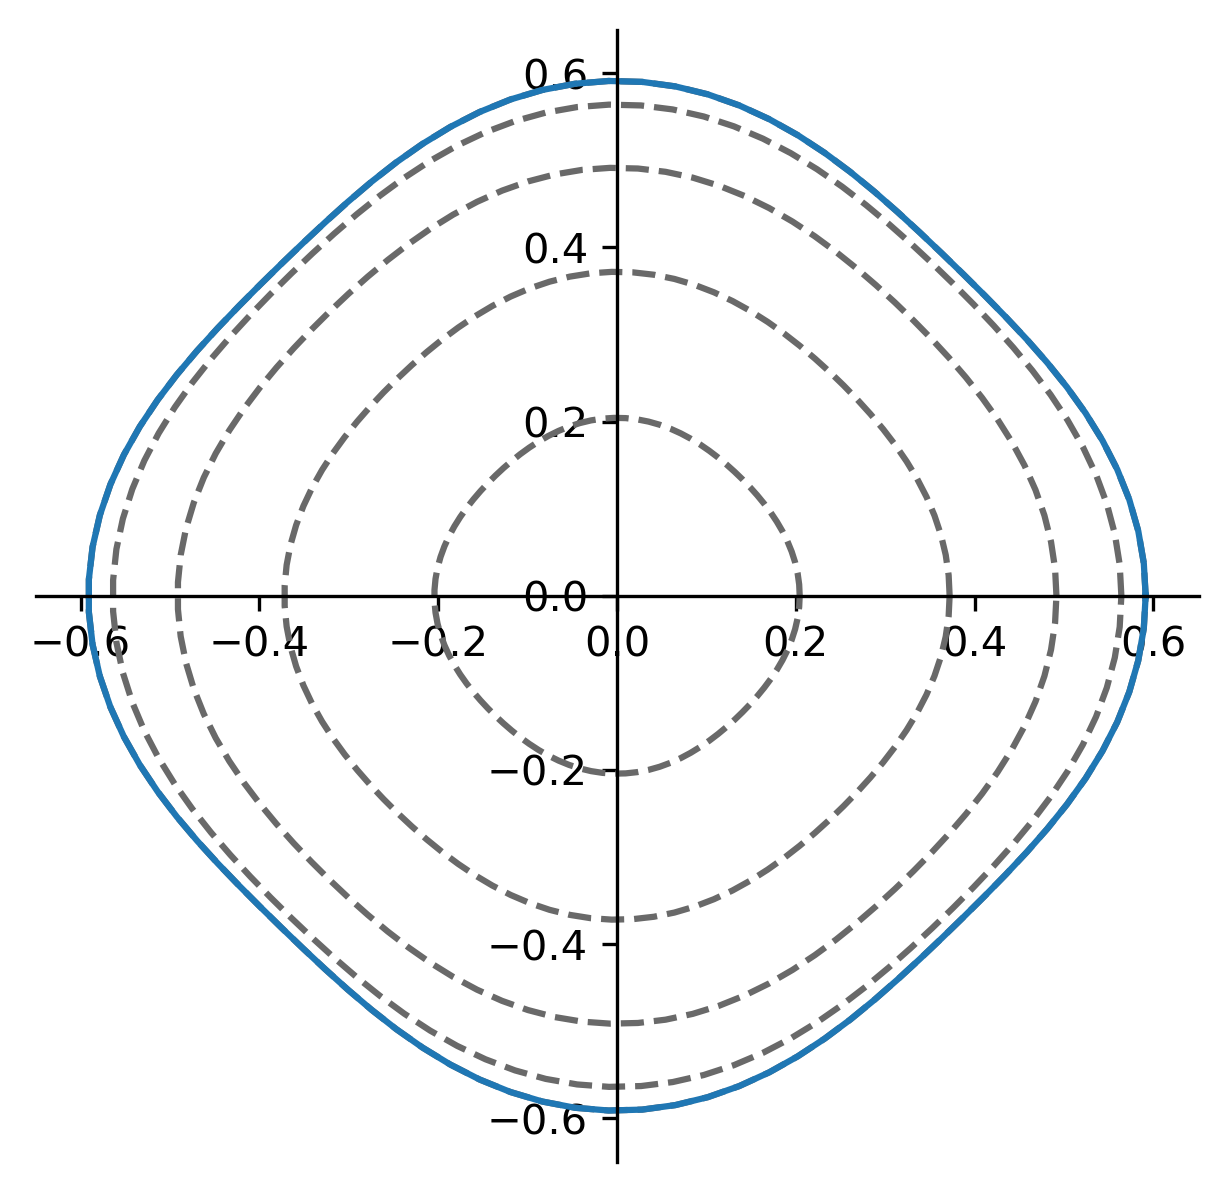

In [29]:
fig = plt.figure(figsize=(5,5), dpi=300)
ax=fig.add_subplot(1,1,1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in np.arange(0,100,20):
    ax.plot(x[i], y[i],linestyle='--',color='dimgrey')

ax.plot(x[0], y[0])
fig.savefig('Non-circular-per005.pdf', bbox_inches='tight')

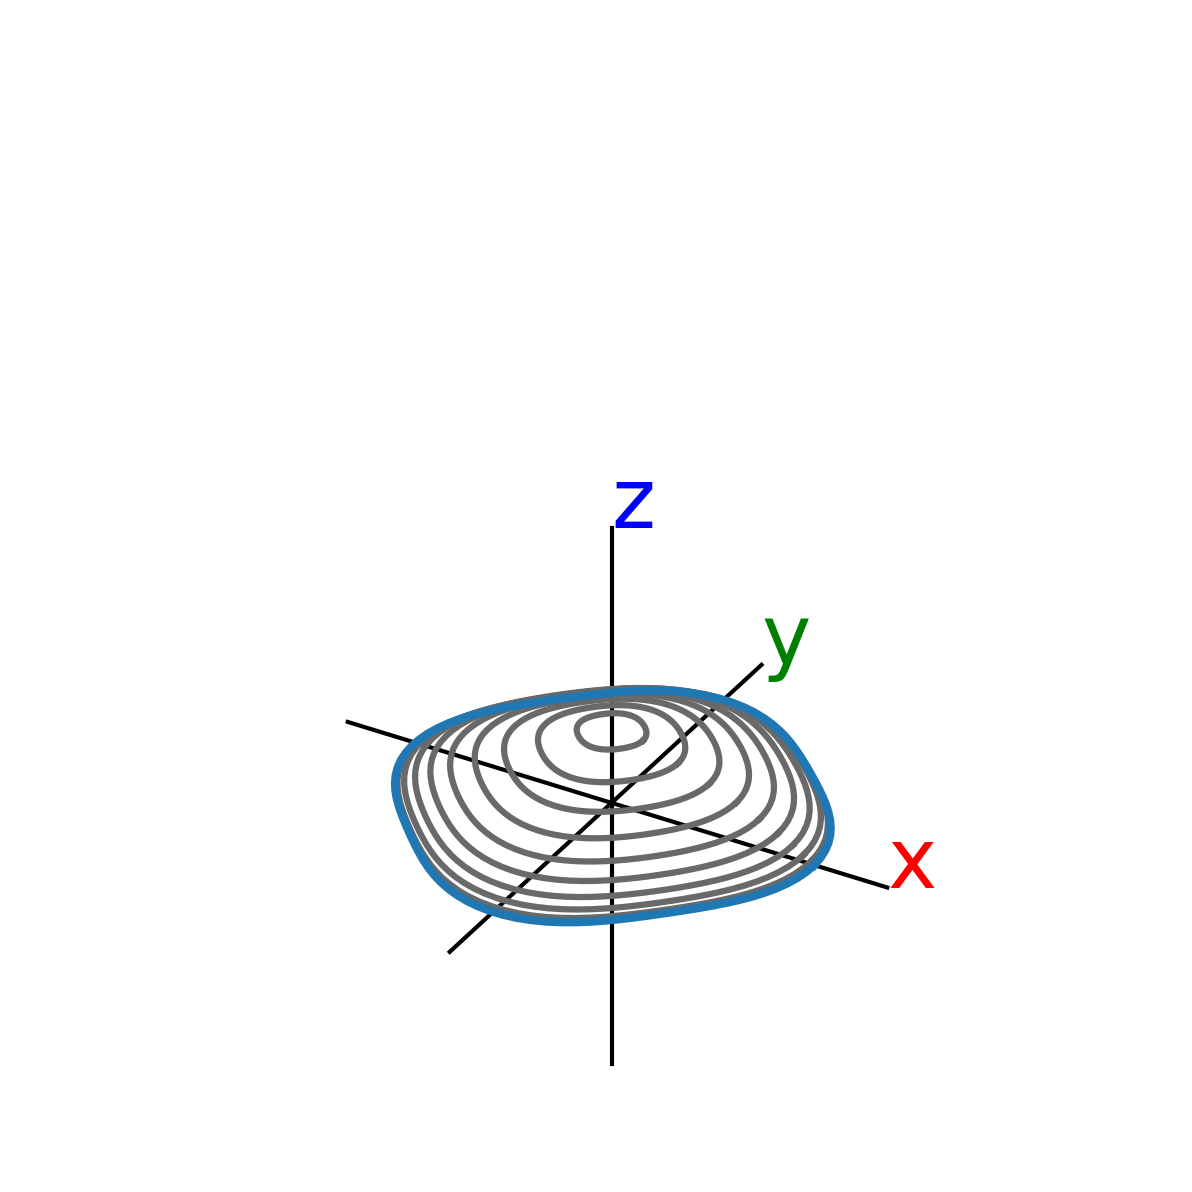

In [30]:
fig = plt.figure(figsize = (5,5), dpi=300)
ax = plt.axes(projection='3d')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

val = [0.8,0,0]
labels = ['x', 'y', 'z']
colors = ['r', 'g', 'b']
for v in range(3):
    axx = [val[v-0], -val[v-0]]
    axy = [val[v-1], -val[v-1]]
    axz = [val[v-2], -val[v-2]]
    ax.plot(axx,axy,axz,'k-', linewidth=1)
    ax.text(val[v-0], val[v-1], val[v-2], labels[v], color=colors[v], fontsize=20)


for i in np.arange(1,100,10):
        ax.plot(x[i], y[i],z_0*z[i], color='dimgrey')
ax.plot(x[0], y[0],z_0*z[0], lw=2)
ax.set_zlim(0,1.3)
ax.set_axis_off()
ax.grid(False)
fig.savefig('Non-circular-per005_with_xyz.pdf', bbox_inches='tight')

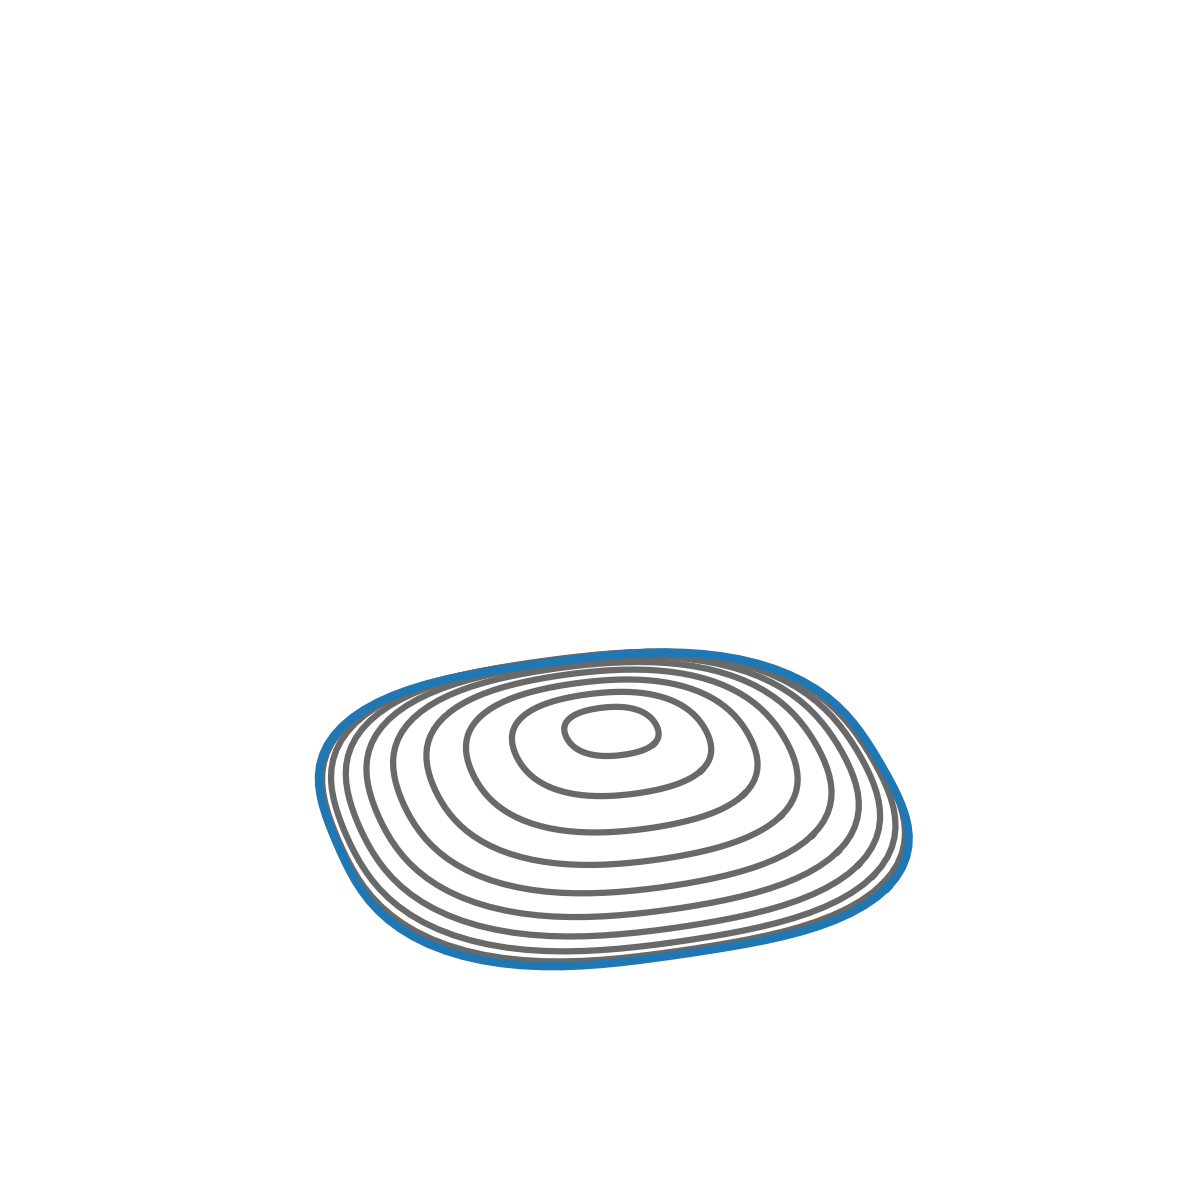

In [31]:
fig = plt.figure(figsize = (5,5), dpi=300)
ax = plt.axes(projection='3d')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(1,100,10):
        ax.plot(x[i], y[i],z_0*z[i], color='dimgrey')
ax.plot(x[0], y[0],z_0*z[0], lw=2)
ax.set_zlim(0,1.3)
ax.set_axis_off()
ax.grid(False)
fig.savefig('Non-circular-per005_3D.pdf', bbox_inches='tight')

### pertubation=0.07

In [32]:
Radius = radius(THETA_RANGES, C_RANGES, m_matrix[4], 4,Pers[3])
Radius.shape
x = Radius*np.cos(THETA_RANGES)
y = Radius*np.sin(THETA_RANGES)
z = Height[4]*(C_RANGES)**n_matrix[4]
z_0 = np.ones(THETA_RANGES.shape[0])

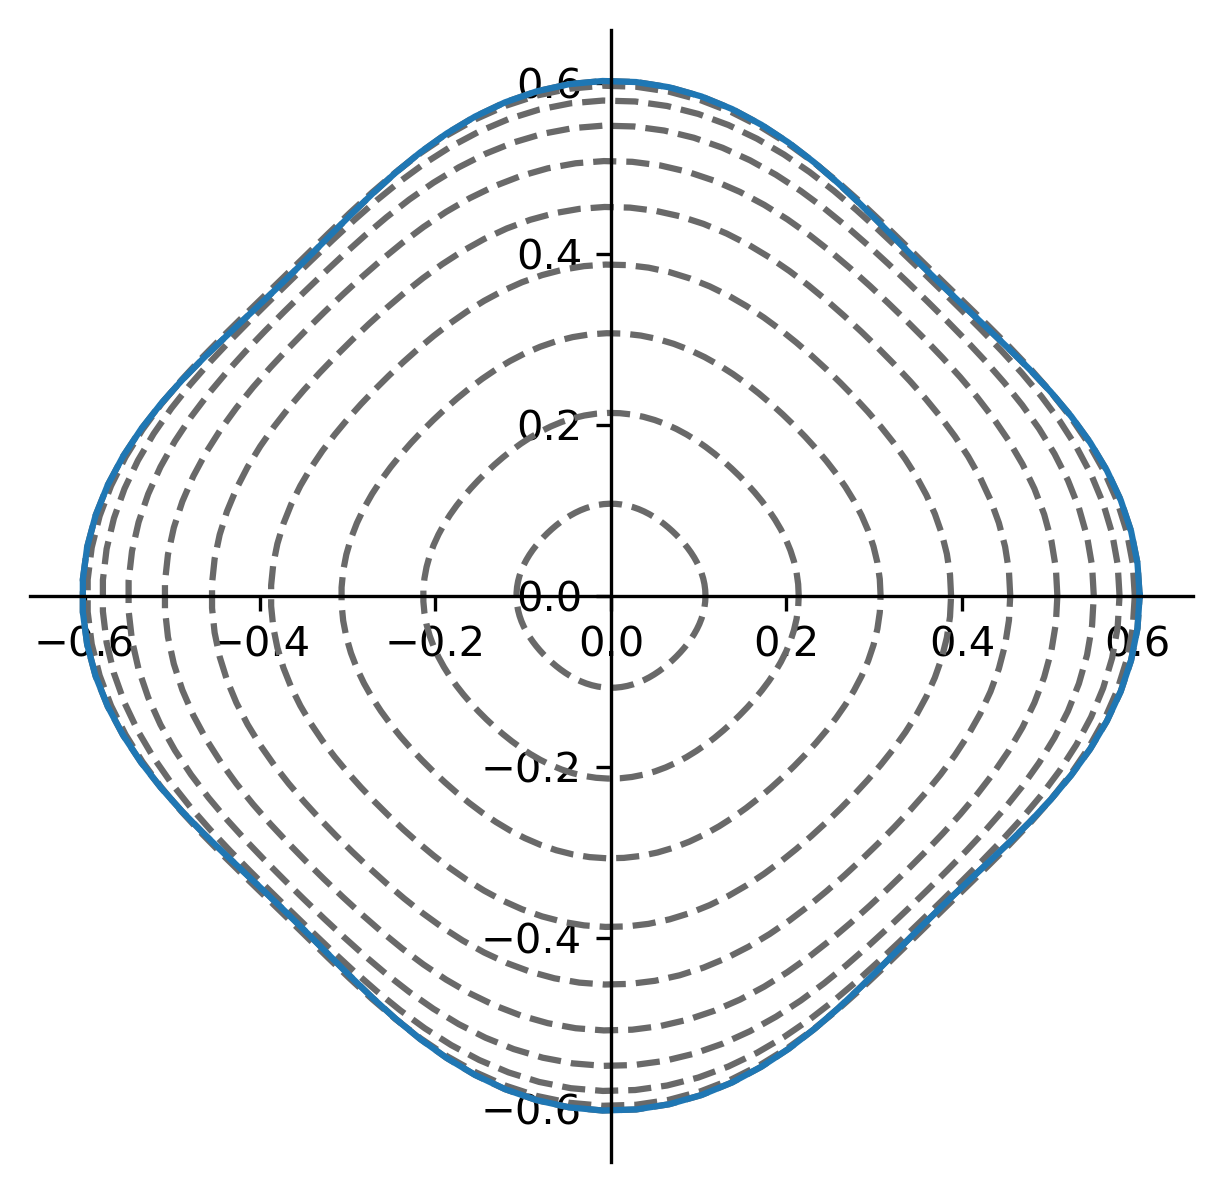

In [33]:
fig = plt.figure(figsize=(5,5), dpi=300)
ax=fig.add_subplot(1,1,1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in np.arange(0,100,10):
    ax.plot(x[i], y[i],linestyle='--',color='dimgrey')

ax.plot(x[0], y[0])
fig.savefig('Non-circular-pertubation007.pdf', bbox_inches='tight')

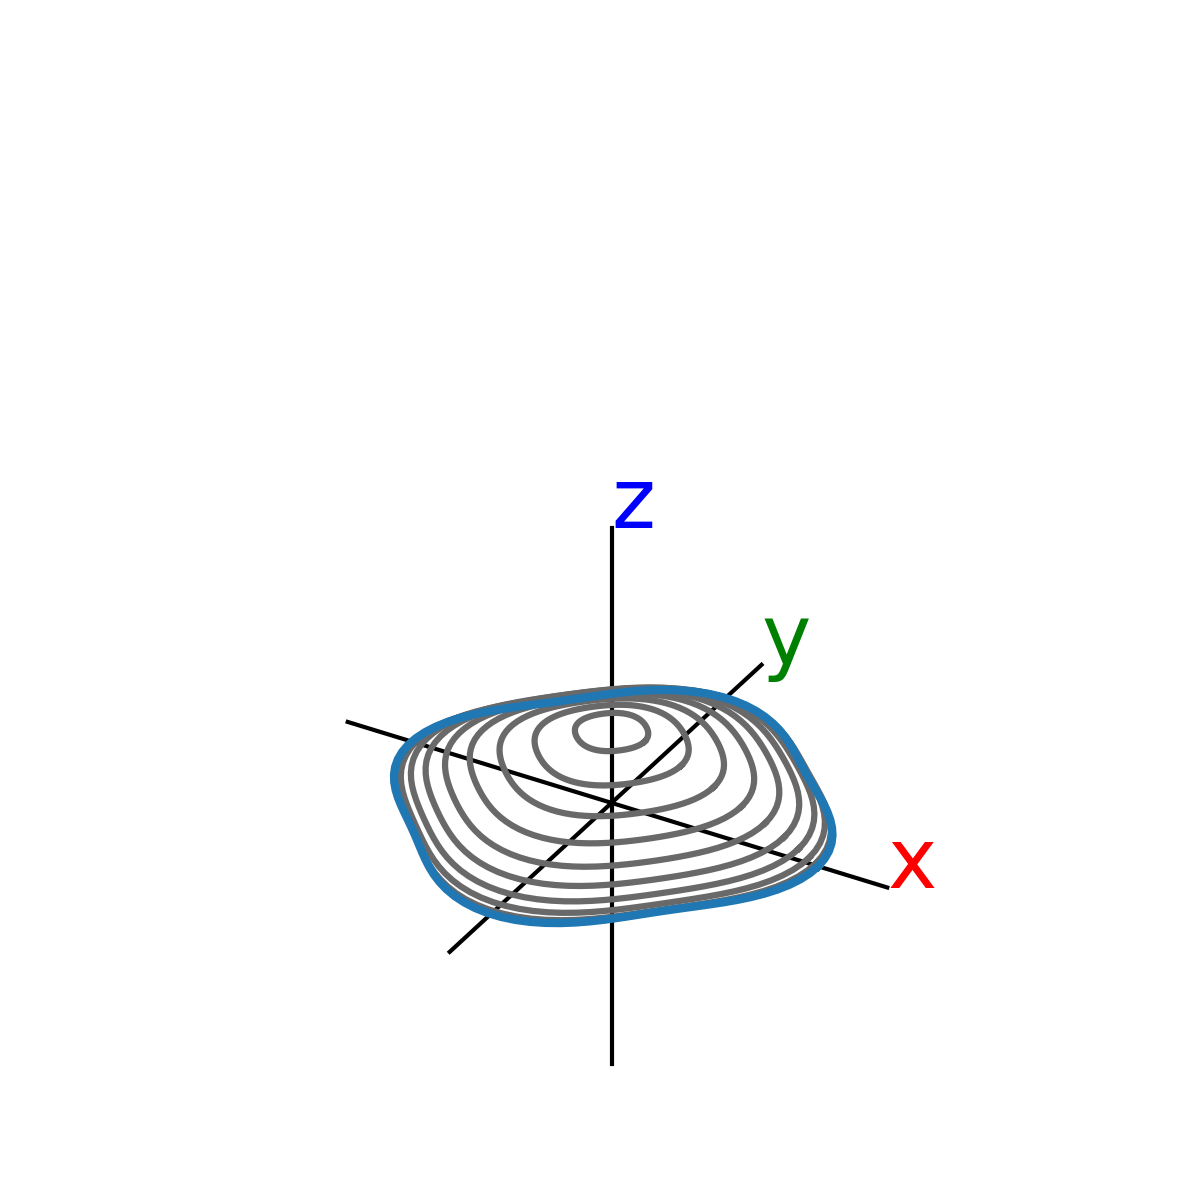

In [34]:
fig = plt.figure(figsize = (5,5), dpi=300)
ax = plt.axes(projection='3d')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

val = [0.8,0,0]
labels = ['x', 'y', 'z']
colors = ['r', 'g', 'b']
for v in range(3):
    axx = [val[v-0], -val[v-0]]
    axy = [val[v-1], -val[v-1]]
    axz = [val[v-2], -val[v-2]]
    ax.plot(axx,axy,axz,'k-', linewidth=1)
    ax.text(val[v-0], val[v-1], val[v-2], labels[v], color=colors[v], fontsize=20)


for i in np.arange(1,100,10):
        ax.plot(x[i], y[i],z_0*z[i], color='dimgrey')
ax.plot(x[0], y[0],z_0*z[0], lw=2)
ax.set_zlim(0,1.3)
ax.set_axis_off()
ax.grid(False)
fig.savefig('Non-circular-pertubation007_with_xyz.pdf', bbox_inches='tight')

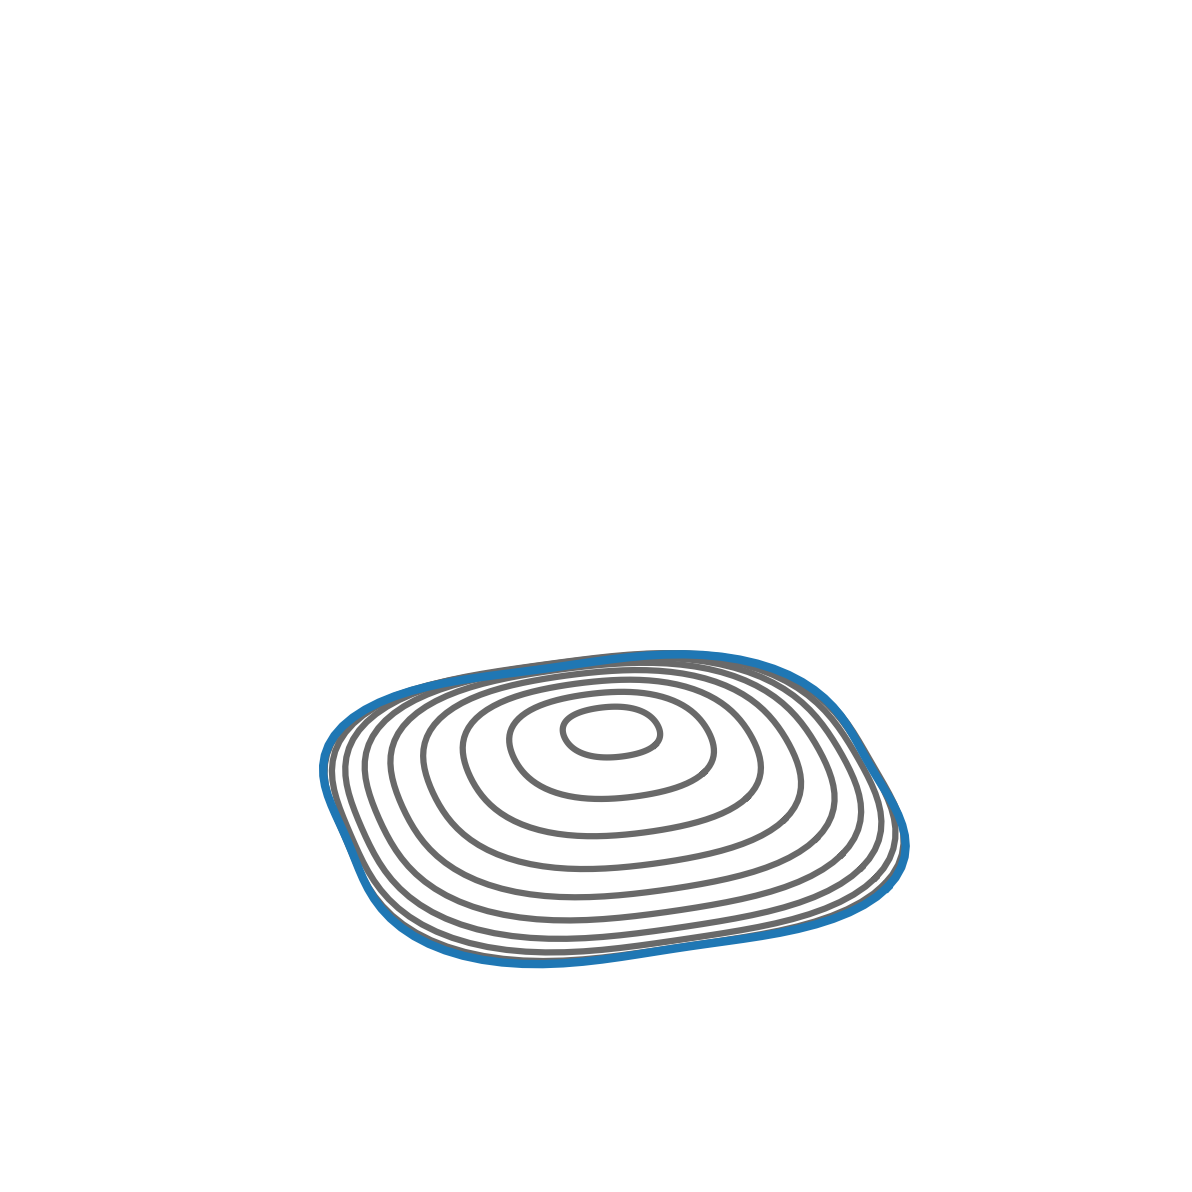

In [35]:
fig = plt.figure(figsize = (5,5), dpi=300)
ax = plt.axes(projection='3d')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(1,100,10):
        ax.plot(x[i], y[i],z_0*z[i], color='dimgrey')
ax.plot(x[0], y[0],z_0*z[0], lw=2)
ax.set_zlim(0,1.3)
ax.set_axis_off()
ax.grid(False)
fig.savefig('Non-circular-pertubation007_3D.pdf', bbox_inches='tight')

### Pertubation 0.1

In [36]:
Radius = radius(THETA_RANGES, C_RANGES, m_matrix[4], 4,Pers[4])
Radius.shape
x = Radius*np.cos(THETA_RANGES)
y = Radius*np.sin(THETA_RANGES)
z = Height[4]*(C_RANGES)**n_matrix[4]
z_0 = np.ones(THETA_RANGES.shape[0])

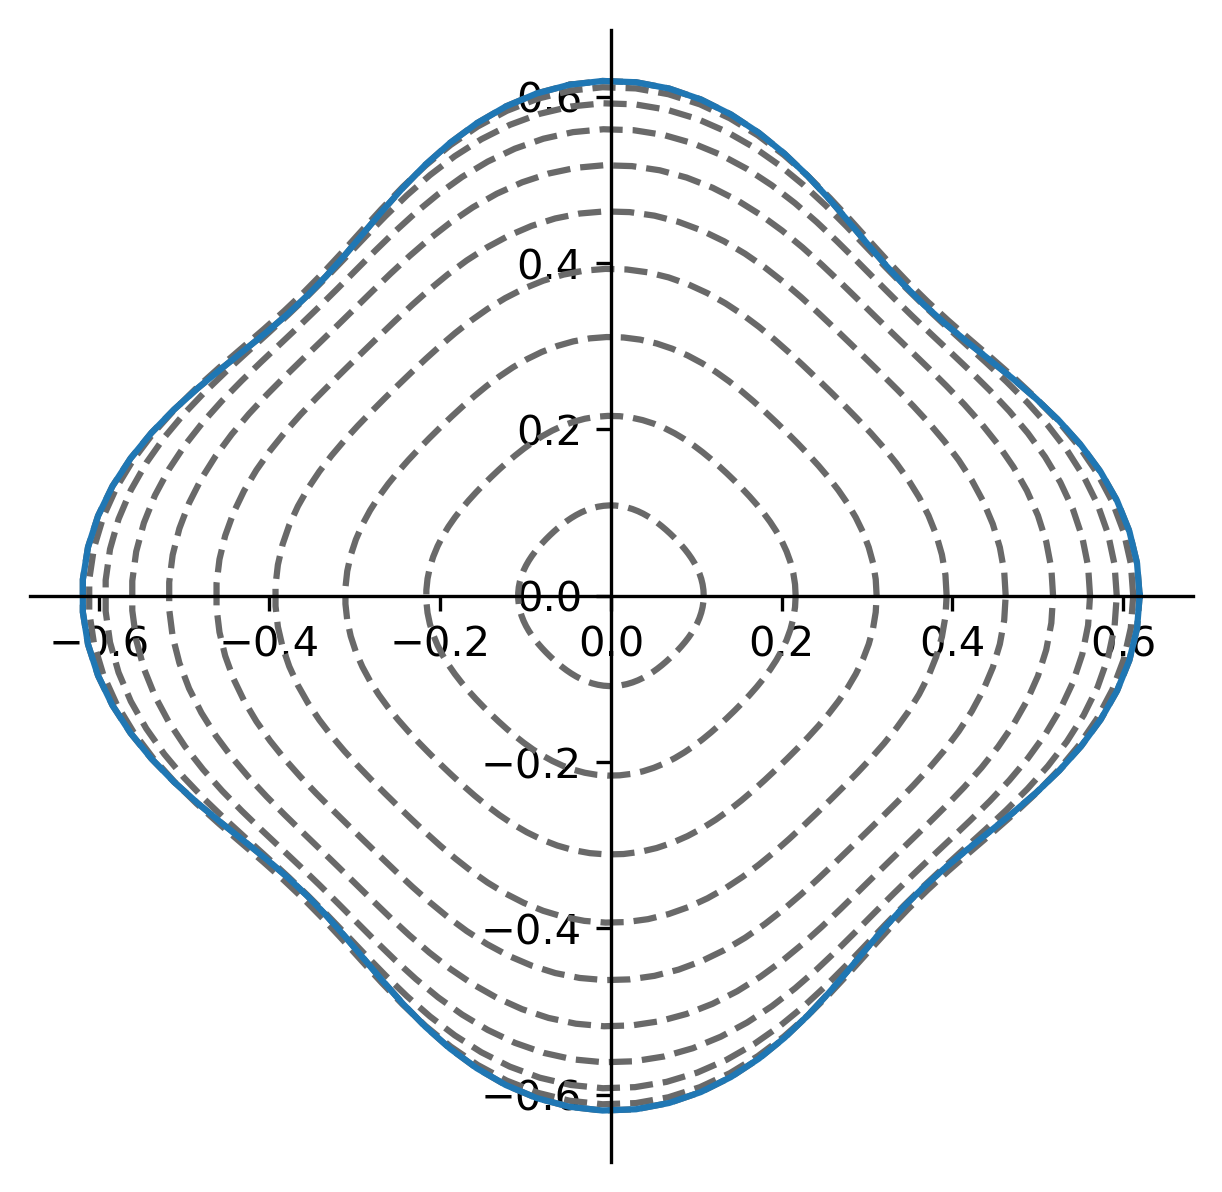

In [37]:
fig = plt.figure(figsize=(5,5), dpi=300)
ax=fig.add_subplot(1,1,1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in np.arange(0,100,10):
    ax.plot(x[i], y[i],linestyle='--',color='dimgrey')

ax.plot(x[0], y[0])
fig.savefig('Non-circular-pertubation01.pdf', bbox_inches='tight')

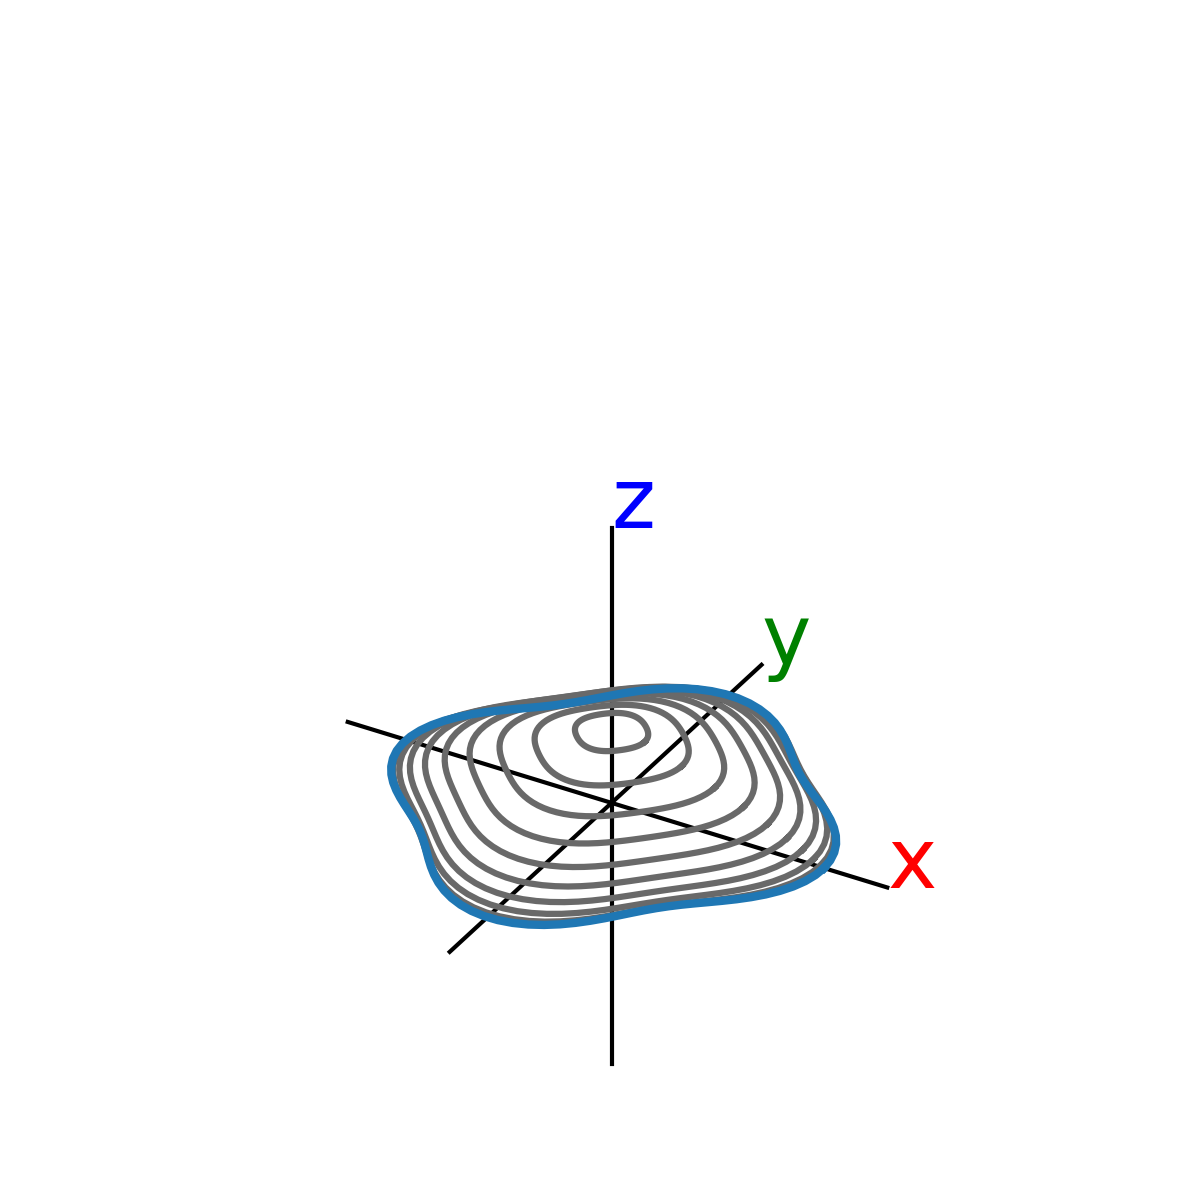

In [38]:
fig = plt.figure(figsize = (5,5), dpi=300)
ax = plt.axes(projection='3d')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

val = [0.8,0,0]
labels = ['x', 'y', 'z']
colors = ['r', 'g', 'b']
for v in range(3):
    axx = [val[v-0], -val[v-0]]
    axy = [val[v-1], -val[v-1]]
    axz = [val[v-2], -val[v-2]]
    ax.plot(axx,axy,axz,'k-', linewidth=1)
    ax.text(val[v-0], val[v-1], val[v-2], labels[v], color=colors[v], fontsize=20)


for i in np.arange(1,100,10):
        ax.plot(x[i], y[i],z_0*z[i], color='dimgrey')
ax.plot(x[0], y[0],z_0*z[0], lw=2)
ax.set_zlim(0,1.3)
ax.set_axis_off()
ax.grid(False)
fig.savefig('Non-circular-per01_with_xyz.pdf', bbox_inches='tight')

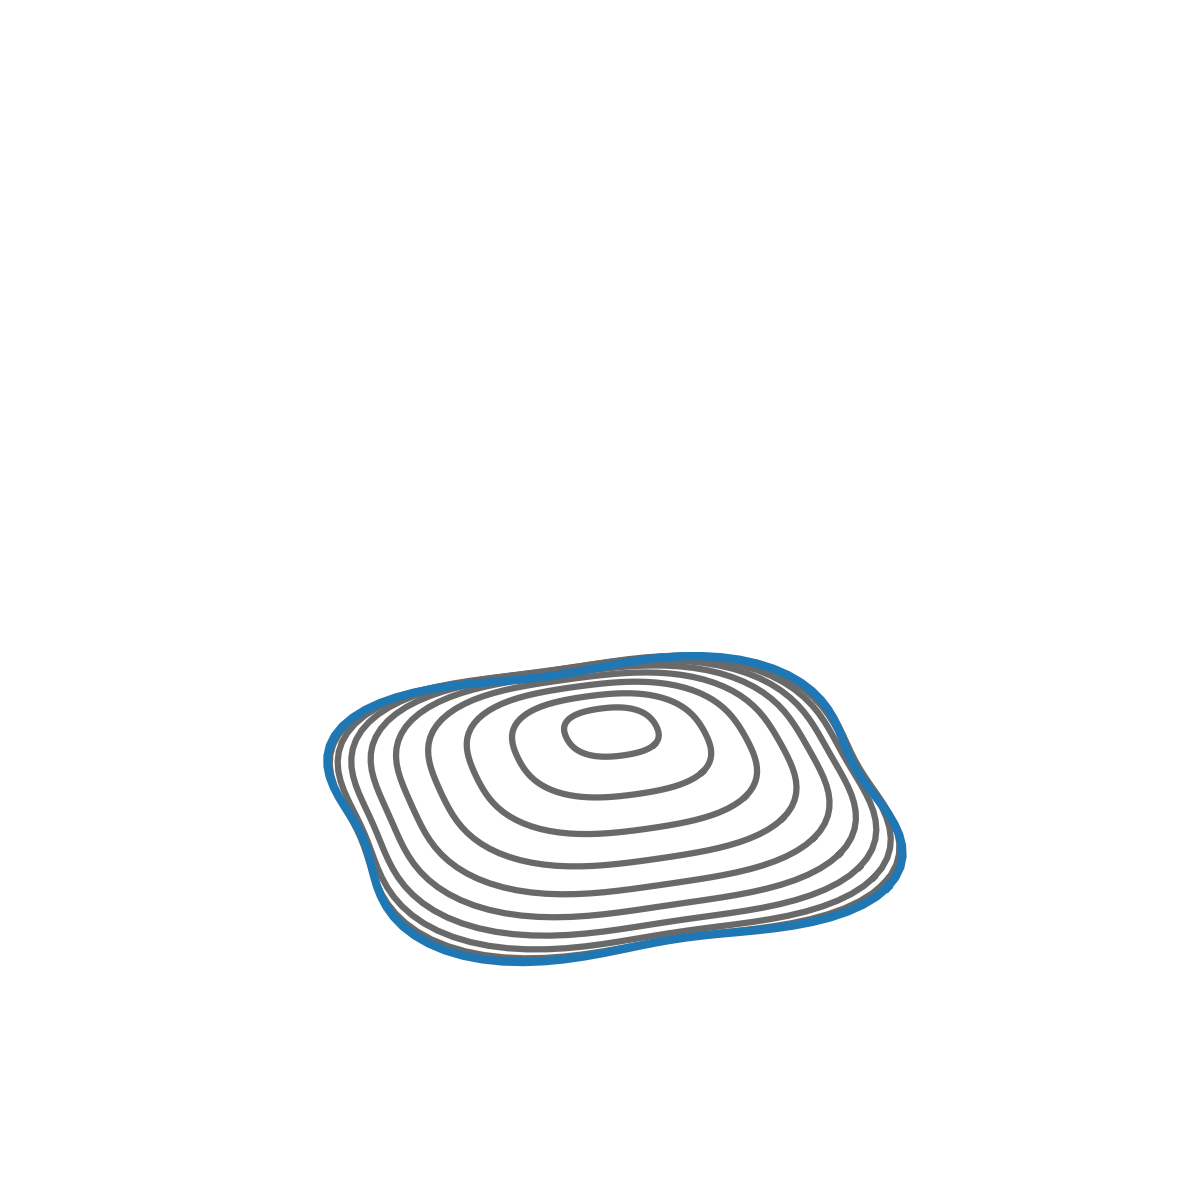

In [39]:
fig = plt.figure(figsize = (5,5), dpi=300)
ax = plt.axes(projection='3d')
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))



for i in np.arange(1,100,10):
        ax.plot(x[i], y[i],z_0*z[i], color='dimgrey')
ax.plot(x[0], y[0],z_0*z[0], lw=2)
ax.set_zlim(0,1.3)
ax.set_axis_off()
ax.grid(False)
fig.savefig('Non-circular-pertubation1_3D.pdf', bbox_inches='tight')